In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data/electricity_bill_dataset.csv')
df.head()

,Fan,Refrigerator,AirConditioner,Television,Monitor,Month,City,Company,TariffRate,ElectricityBill
0,16,23,2,6,1,10,Hyderabad,Tata Power Company Ltd.,8.4,3225.6
1,19,22,2,3,1,5,Vadodara,NHPC,7.8,3806.4
2,7,20,2,6,7,7,Shimla,Jyoti Structure,7.7,3203.2
3,7,22,3,21,1,6,Mumbai,Power Grid Corp,9.2,4370.0
4,11,23,2,11,1,2,Mumbai,Ratnagiri Gas and Power Pvt. Ltd. (RGPPL),9.2,4204.4


In [48]:
df.drop(['City', 'Company'], axis=1, inplace=True)
df['Total'] = df['Fan']+df['Refrigerator']+df['AirConditioner']+df['Television']+df['Monitor']
df.head()

,Fan,Refrigerator,AirConditioner,Television,Monitor,Month,TariffRate,ElectricityBill,Total
0,16,23,2,6,1,10,8.4,3225.6,48
1,19,22,2,3,1,5,7.8,3806.4,47
2,7,20,2,6,7,7,7.7,3203.2,42
3,7,22,3,21,1,6,9.2,4370.0,54
4,11,23,2,11,1,2,9.2,4204.4,48


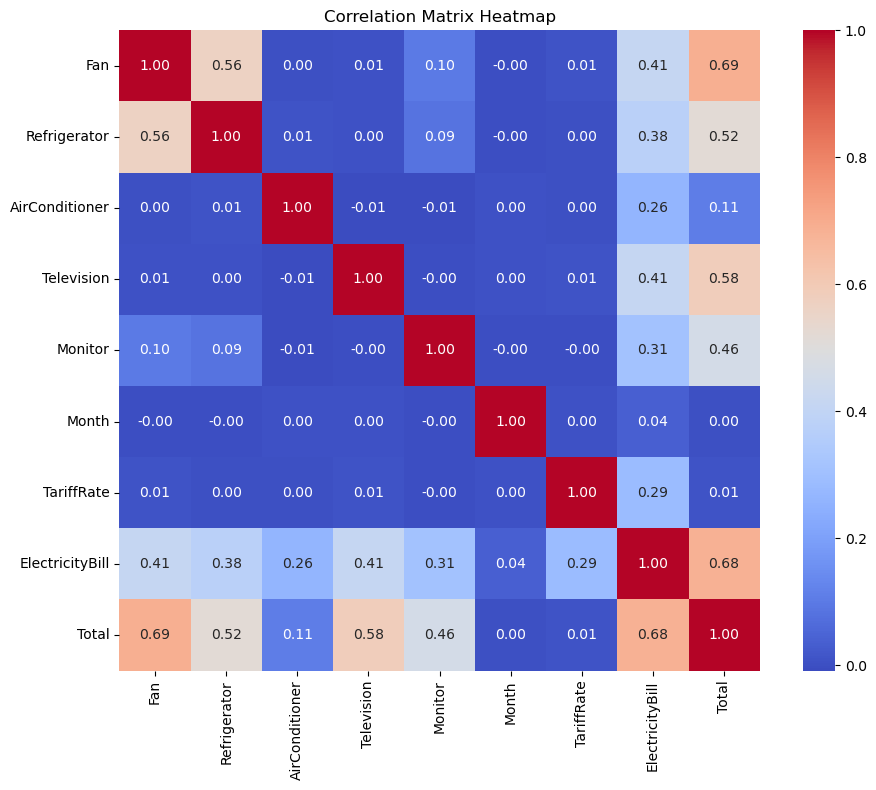

In [49]:
numeric_df = df.select_dtypes(include='number')

# Computing correlation matrix
corr_matrix = numeric_df.corr()

# Plotting heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

In [50]:
df.shape

(45345, 9)

In [51]:
# Eliminating Outliers by IQR analysis

def remove_outliers_iqr(data, columns):
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        data = data[(data[col] >= lower) & (data[col] <= upper)]
    return data

numeric_cols = ['Fan', 'Refrigerator', 'AirConditioner', 'Television', 'Monitor', 'TariffRate', 'ElectricityBill']
df_iqr = remove_outliers_iqr(df, numeric_cols)

df.shape

(45345, 9)

In [52]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

X = df.drop('ElectricityBill', axis=1)
y = df['ElectricityBill']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
LR = LinearRegression()
LR.fit(X_train, y_train)
pred_lr = LR.predict(X_test)
print("Linear Regression R2:", r2_score(y_test, pred_lr))
print("Linear Regression MSE:", mean_squared_error(y_test, pred_lr))

RF = RandomForestRegressor(random_state=42)
RF.fit(X_train, y_train)
pred_rf = RF.predict(X_test)
print("Random Forest R2:", r2_score(y_test, pred_rf))
print("Random Forest MSE:", mean_squared_error(y_test, pred_rf))

GB = GradientBoostingRegressor(random_state=42)
GB.fit(X_train, y_train)
pred_gb = GB.predict(X_test)
print("Gradient Boosting R2:", r2_score(y_test, pred_gb))
print("Gradient Boosting MSE:", mean_squared_error(y_test, pred_gb))

Linear Regression R2: 0.5785314735367129
Linear Regression MSE: 480229.24234320794
Random Forest R2: 0.5336550100461115
Random Forest MSE: 531362.3370062358
Gradient Boosting R2: 0.590839332309022
Gradient Boosting MSE: 466205.434343376


In [54]:
# Hyperparameter Tuning on GradientBoostingRegressor 

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
GB = GradientBoostingRegressor(random_state=42)

# Applying GridSearchCV
grid_params = {
    'n_estimators': [250, 300, 350, 400],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [2, 3, 4]
}

grid_search = GridSearchCV(GB, grid_params, cv=2)
grid_search.fit(X_train, y_train)
GB = grid_search.best_estimator_
print("Best Parameters (GridSearchCV):", grid_search.best_params_)
pred_gb_grid = GB.predict(X_test)
print("GB (GridSearchCV) R2:", r2_score(y_test, pred_gb_grid))
print("GB (GridSearchCV) MSE:", mean_squared_error(y_test, pred_gb_grid))


Best Parameters (GridSearchCV): {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300}
GB (GridSearchCV) R2: 0.5947663717208312
GB (GridSearchCV) MSE: 461730.8910667754


In [55]:
# Applying RandomizedSearchCV

random_params = {
    'n_estimators': [200, 250, 350],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4, 5],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_split': [2, 4, 6]
}

random_search = RandomizedSearchCV(GB, random_params, n_iter=10, cv=2, random_state=42)
random_search.fit(X_train, y_train)
GB = random_search.best_estimator_
print("Best Parameters (RandomizedSearchCV):", random_search.best_params_)
pred_gb_random = GB.predict(X_test)
print("GB (RandomizedSearchCV) R2:", r2_score(y_test, pred_gb_random))
print("GB (RandomizedSearchCV) MSE:", mean_squared_error(y_test, pred_gb_random))

Best Parameters (RandomizedSearchCV): {'subsample': 0.8, 'n_estimators': 250, 'min_samples_split': 4, 'max_depth': 3, 'learning_rate': 0.05}
GB (RandomizedSearchCV) R2: 0.5939079419466309
GB (RandomizedSearchCV) MSE: 462709.00225227344


In [56]:
# Declaring tuned GradientBoostingRegressor with GridSearchCV as final model while also assigning it to a variable
final_model = grid_search.best_estimator_

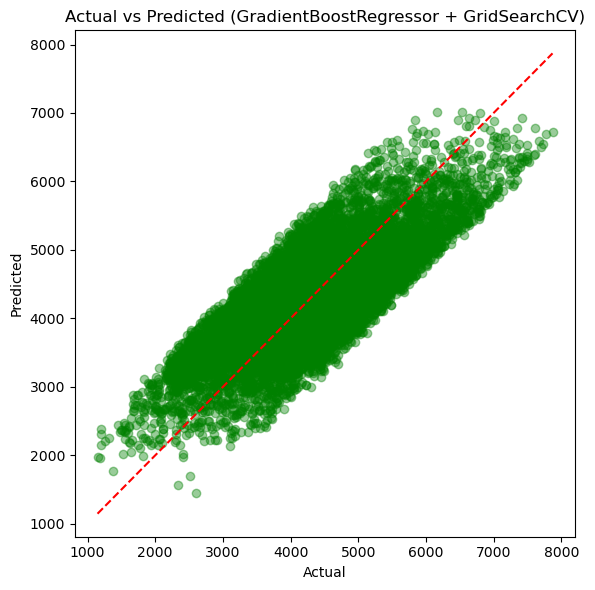

In [57]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, pred_gb_grid, alpha=0.4, color="green")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (Tuned GradientBoostingRegressor with GridSearchCV)")
plt.tight_layout()
plt.show()


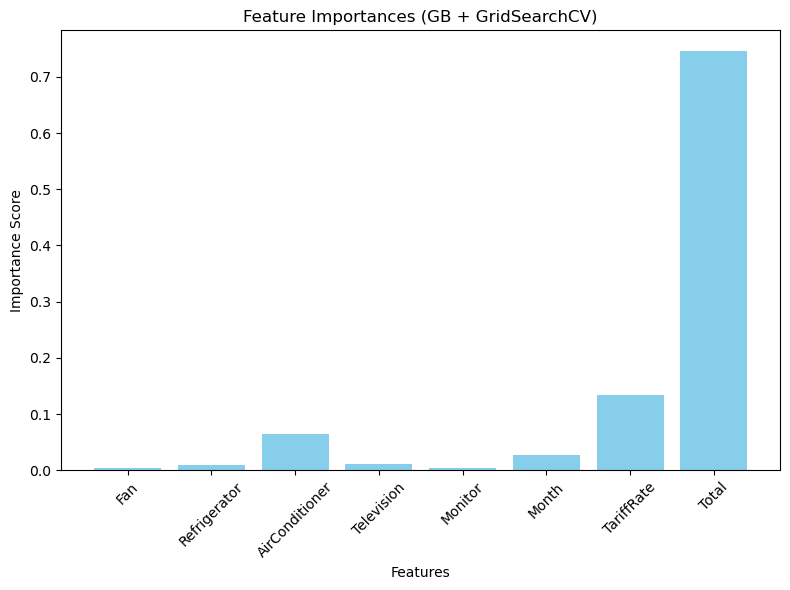

In [ ]:
importances = GB.feature_importances_
feature_names = X.columns

# Plotting distribution of each column's contribution to predict result

plt.figure(figsize=(8, 6))
plt.bar(feature_names, importances, color='skyblue')
plt.title("Feature Importances (Tuned GradientBoosting with GridSearchCV)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [59]:
import joblib

joblib.dump(final_model, 'best_model_gb_grid.pkl')


['best_model_gb_grid.pkl']

In [60]:
loaded_model = joblib.load('best_model_gb_grid.pkl')
pred_loaded = loaded_model.predict(X_test)
print("Loaded model R²:", r2_score(y_test, pred_loaded))

Loaded model R²: 0.5947663717208312


In [63]:
# Tesing on sample input

user_input = {
    'Fan': [20],
    'Refrigerator': [21],
    'AirConditioner': [0],
    'Television': [3],
    'Monitor': [4],
    'Month': [7],
    'TariffRate': [5.3]
}

# Convert to DataFrame
user_df = pd.DataFrame(user_input)
user_df['Total'] = user_df[['Fan', 'Refrigerator', 'AirConditioner', 'Television', 'Monitor']].sum(axis=1)

# Predict using the loaded model
predicted_bill = loaded_model.predict(user_df)
print("Predicted Electricity Bill:", predicted_bill[0])


Predicted Electricity Bill: 3161.9568023411384


In [64]:
!pip install gradio


In [67]:
import gradio as gr
model = joblib.load('best_model_gb_grid.pkl')

# Define prediction function with all 7 inputs
def predict_bill(fan, refrigerator, ac, tv, monitor, month, tariff_rate):
    if month == 0:
        return "⚠️ Please select the month."
    total = fan + refrigerator + ac + tv + monitor
    if fan == 0 and refrigerator == 0 and ac == 0 and tv == 0 and monitor == 0:
        return "⚠️ Please turn on at least one appliance."

# Using a numpy array to store input values and total
    input_array = np.array([[fan, refrigerator, ac, tv, monitor, month, tariff_rate,total]])
    prediction = model.predict(input_array)
    return f"Predicted Electricity Bill: ₹{prediction[0]:.2f}"

# Build the Gradio interface
interface = gr.Interface(
    fn=predict_bill,
    inputs=[
        gr.Number(label="Fan (Hours/Day)"),
        gr.Number(label="Refrigerator (Hours/Day)"),
        gr.Number(label="Air Conditioner (Hours/Day)"),
        gr.Number(label="Television (Hours/Day)"),
        gr.Number(label="Monitor (Hours/Day)"),
        gr.Number(label="Month (1 to 12)"),
        gr.Number(label="Tariff Rate (₹ per Unit)"),
    ],
    outputs=gr.Textbox(label="Estimated Monthly Electricity Bill"),
    title="Electricity Bill Estimator",
    description="Enter appliance usage, month, and tariff rate to estimate your electricity bill"
)

# Launch the app
interface.launch()


* Running on local URL:  http://127.0.0.1:7866
* To create a public link, set `share=True` in `launch()`.


In [68]:
interface.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
* Running on public URL: https://574dde25ed11cd5c55.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
